In [1]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import maxflow
import argparse
from matplotlib.pyplot import figure

%matplotlib inline

## Input directories

In [2]:
image_dir = r"C:\Users\lucki\WORK\UMBC\DAA\DAA_641-Spring_22-Project_1\images\hut"
src = cv2.imread(os.path.join(image_dir, 'src.jpg'))
sink = cv2.imread(os.path.join(image_dir, 'target.jpg'))
mask = cv2.imread(os.path.join(image_dir, 'mask.png'))

In [3]:
def compute_edge_weights(src, sink):
    """
    Computes edge weights based on matching quality cost.
    :param src: image to be blended (foreground)
    :param sink: background image
    """
    edge_weights = np.zeros((src.shape[0], src.shape[1], 2))

    # Create shifted versions of the matrices for vectorized operations.
    src_left_shifted = np.roll(src, -1, axis=1)
    sink_left_shifted = np.roll(sink, -1, axis=1)
    src_up_shifted = np.roll(src, -1, axis=0)
    sink_up_shifted = np.roll(sink, -1, axis=0)

    # Assign edge weights.
    # For numerical stability, avoid divide by 0.
    eps = 1e-10

    # Right neighbor.
    weight = np.sum(np.square(src - sink, dtype=np.float) +
                    np.square(src_left_shifted - sink_left_shifted, 
                    dtype=np.float),
                    axis=2)
    norm_factor = np.sum(np.square(src - src_left_shifted, dtype=np.float) +
                         np.square(sink - sink_left_shifted, 
                         dtype=np.float),
                         axis=2)
    edge_weights[:, :, 0] = weight / (norm_factor + eps)

    # Bottom neighbor.
    weight = np.sum(np.square(src - sink, dtype=np.float) +
                    np.square(src_up_shifted - sink_up_shifted,
                    dtype=np.float),
                    axis=2)
    norm_factor = np.sum(np.square(src - src_up_shifted, dtype=np.float) +
                         np.square(sink - sink_up_shifted, 
                         dtype=np.float),
                         axis=2)
    edge_weights[:, :, 1] = weight / (norm_factor + eps)
    
    return edge_weights

In [4]:
assert (src.shape == sink.shape), f"Source and sink dimensions must be the same: {str(src.shape)} != {str(sink.shape)}"

# Create the graph
graph = maxflow.Graph[float]()
# Add the nodes. node_ids has the identifiers of the nodes in the grid.
node_ids = graph.add_grid_nodes((src.shape[0], src.shape[1]))

edge_weights = compute_edge_weights(src, sink)

In [5]:
# Add non-terminal edges
patch_height = src.shape[0]
patch_width = src.shape[1]
for row_idx in range(patch_height):
    for col_idx in range(patch_width):
        # right neighbor
        if col_idx + 1 < patch_width:
            weight = edge_weights[row_idx, col_idx, 0]
            graph.add_edge(node_ids[row_idx][col_idx],
                           node_ids[row_idx][col_idx + 1],
                           weight,
                           weight)

        # bottom neighbor
        if row_idx + 1 < patch_height:
            weight = edge_weights[row_idx, col_idx, 1]
            graph.add_edge(node_ids[row_idx][col_idx],
                           node_ids[row_idx + 1][col_idx],
                           weight,
                           weight)

        # Add terminal edge capacities for the pixels constrained to
        # belong to the source/sink.
        if np.array_equal(mask[row_idx, col_idx, :], [0, 255, 255]):
            graph.add_tedge(node_ids[row_idx][col_idx], 0, np.inf)
        elif np.array_equal(mask[row_idx, col_idx, :], [255, 128, 0]):
            graph.add_tedge(node_ids[row_idx][col_idx], np.inf, 0)

In [6]:
# Compute max flow / min cut.
flow = graph.maxflow()

In [7]:
sgm = graph.get_grid_segments(node_ids)

In [8]:
flow, sgm.shape

(12.058232585748879, (353, 271))

## Get the segments of the nodes in the grid.

In [9]:
canvas = np.zeros(sink.shape, dtype=np.uint8)

In [10]:
src[sgm] = canvas[sgm]

image = src

In [11]:
# Canvas overlay tryout

In [12]:
# img_float32 = np.float32(needed_multi_channel_img)
# lab_image = cv2.cvtColor(img_float32, cv2.COLOR_RGB2HSV)

## PLotting the 2d_graphs

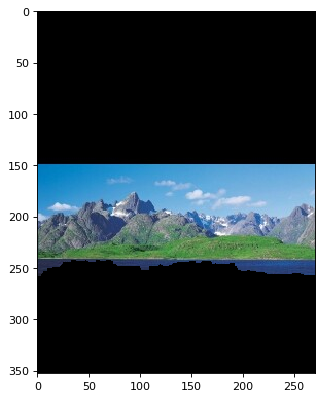

In [13]:
rgb_img = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
figure(figsize=(8, 6), dpi=80)
plt.imshow(rgb_img)
# plt.savefig('src[sgm] = canvas[sgm].png')
plt.show()

# Plotting of ndarray

In [14]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

# Some legacy ouputs

- 1. sink[sgm] = src[sgm] `# OG`
- 2. src[sgm] = canvas[sgm] `# canvas = np.multiply(mask, [0])` ` # source cutted`
- 3. sink[sgm] = canvas[sgm] `# canvas = np.multiply(mask, [0])` ` # target cutted`